In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [4]:
#Load dataset and cutoff at 18288,26-09-2014 00:00
df1 = pd.read_csv("full.csv")
train = df1[df1['ID'] < 18288]
train_original = train.copy()
test = df1[df1['ID'] >= 18288]
test_original = test.copy()

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5112 entries, 18288 to 23399
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        5112 non-null   int64  
 1   Datetime  5112 non-null   object 
 2   Count     0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 159.8+ KB


# Extracting Features

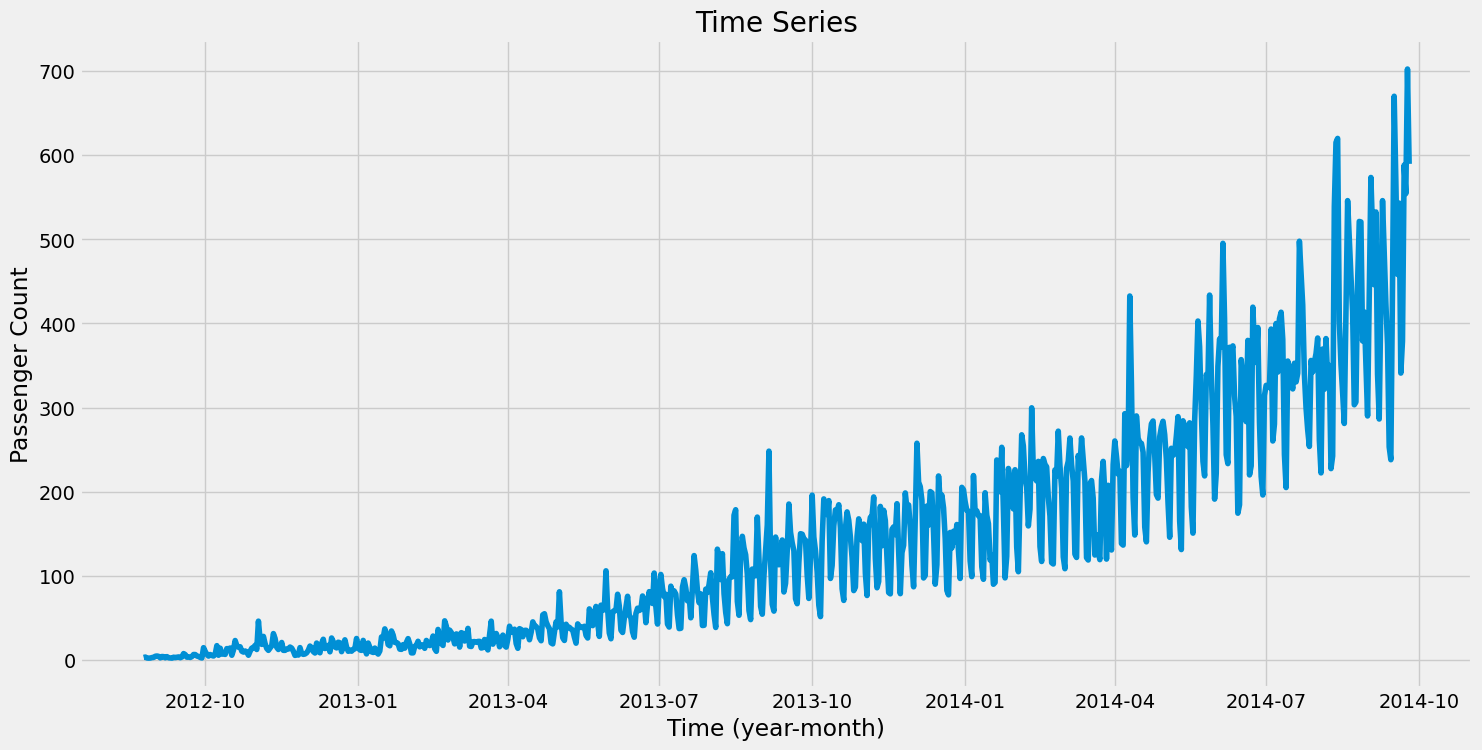

In [ ]:
# Parse datetimes once and index properly 
for df in (train, test, train_original, test_original):
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M', errors='coerce')
    df.set_index('Datetime', inplace=True)

# Calendar features (vectorised) 
for df in (train, test, train_original, test_original):
    idx = df.index
    df['year']         = idx.year
    df['month']        = idx.month
    df['day']          = idx.day
    df['Hour']         = idx.hour
    df['Day of week']  = idx.dayofweek
    df['weekend']      = idx.dayofweek.isin([5, 6]).astype(int)

# Resample to daily means (numeric columns only) 
train = train.resample('D').mean(numeric_only=True)
test  = test.resample('D').mean(numeric_only=True)

# Plot the target after resampling 
plt.figure(figsize=(16, 8))
plt.plot(train['Count'])
plt.title("Time Series")
plt.xlabel("Time (year-month)")
plt.ylabel("Passenger Count")
plt.show()

# Date-based train/validation split (replaces deprecated .ix) 
Train = train.loc['2012-08-25':'2014-06-24'].copy()
valid = train.loc['2014-06-25':'2014-09-25'].copy()

In [10]:
Train

,ID,Count,year,month,day,Hour,Day of week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...,...
2014-06-20,15947.5,379.916667,2014.0,6.0,20.0,11.5,4.0,0.0
2014-06-21,15971.5,220.083333,2014.0,6.0,21.0,11.5,5.0,1.0
2014-06-22,15995.5,230.833333,2014.0,6.0,22.0,11.5,6.0,1.0


# Divide data into training and validation

Train range: 2012-08-25 → 2014-06-24 | n=669
Valid range: 2014-06-25 → 2014-09-25 | n=93


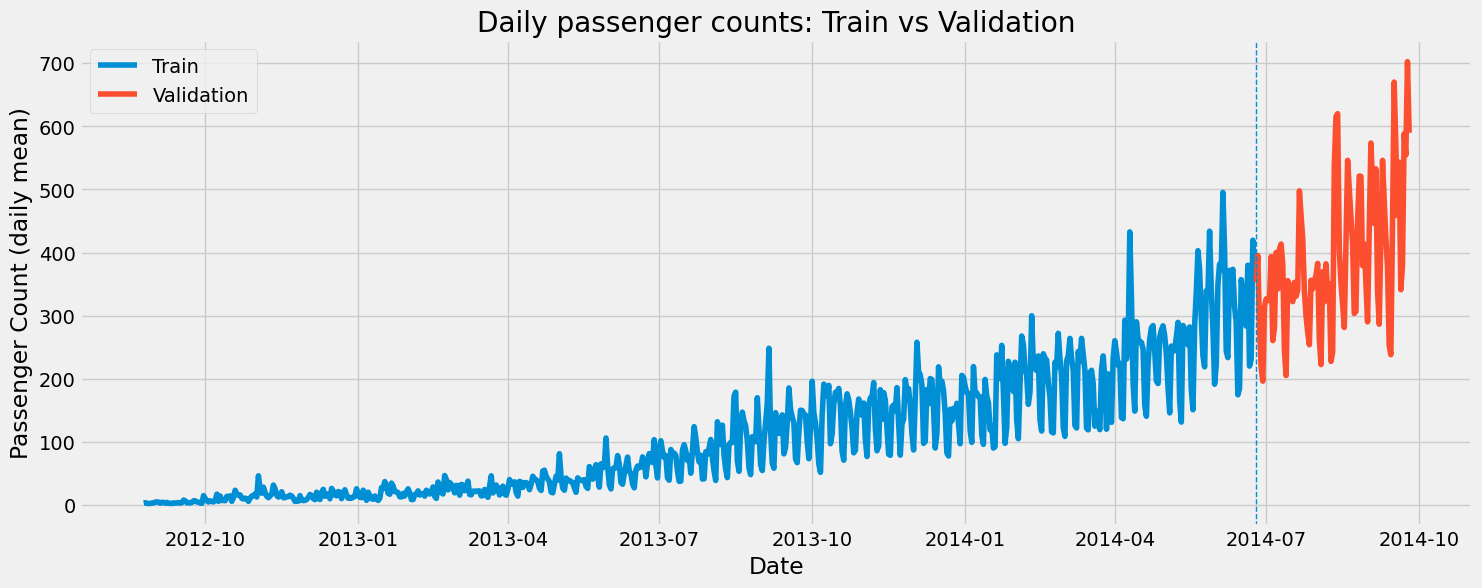

In [11]:
# Divide data into training and validation

# Ensure index is a DatetimeIndex and sorted
assert isinstance(train.index, pd.DatetimeIndex), "Expected a DatetimeIndex on 'train'."
train = train.sort_index()

# Define split dates (align with the exercise window)
cutoff_start_valid = pd.Timestamp('2014-06-25')   # first day of validation
end_valid          = pd.Timestamp('2014-09-25')   # last day of validation

# Slice (label-based). Train ends the day before validation begins.
Train = train.loc[:cutoff_start_valid - pd.Timedelta(days=1)].copy()
valid = train.loc[cutoff_start_valid:end_valid].copy()

# Target series (univariate)
y_train = Train['Count'].astype(float)
y_valid = valid['Count'].astype(float)

# Optional: remove any NaNs introduced by resampling (should be rare if original data covered the range)
y_train = y_train.dropna()
y_valid = y_valid.dropna()

# Quick checks
print(f"Train range: {Train.index.min().date()} → {Train.index.max().date()} | n={len(Train)}")
print(f"Valid range: {valid.index.min().date()} → {valid.index.max().date()} | n={len(valid)}")

# Visual sanity check (overlay + vertical split line)
plt.figure(figsize=(16, 6))
plt.plot(Train.index, y_train, label='Train')
plt.plot(valid.index, y_valid, label='Validation')
plt.axvline(cutoff_start_valid, linestyle='--', linewidth=1)
plt.title("Daily passenger counts: Train vs Validation")
plt.xlabel("Date")
plt.ylabel("Passenger Count (daily mean)")
plt.legend()
plt.show()

# Predicting Timeseries: Naive Approach

                         MAE     RMSE  MAPE (%)  sMAPE (%)
Model                                                     
Naive (Drift)         83.912  103.983    23.799     21.601
Naive (Last)          86.685  111.791    22.918     22.259
Seasonal Naive (7d)   86.320  115.113    20.058     22.961
Naive (Mean)         285.138  305.790    71.047    111.414


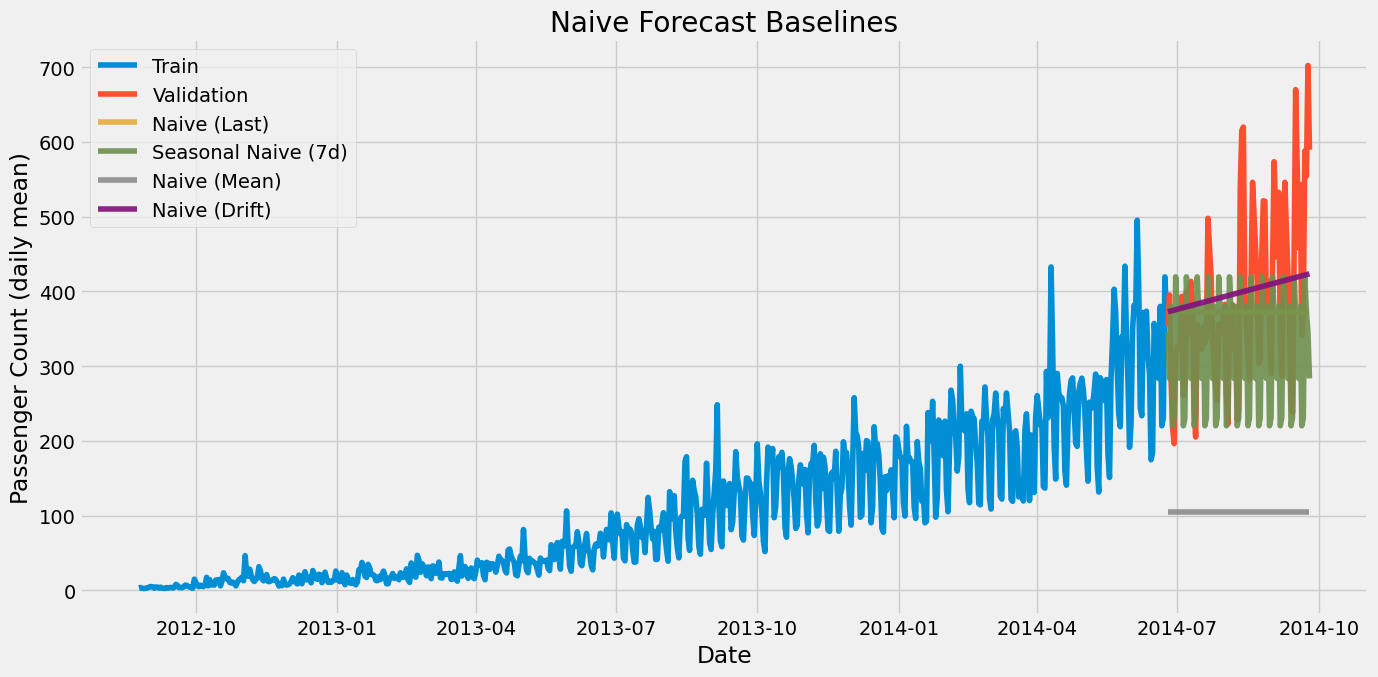

In [12]:
# Naive forecasting baselines and evaluation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the target is present and numeric
y_train = Train['Count'].astype(float)
y_valid = valid['Count'].astype(float)

# 1) Naive (last observed value)
naive_last = pd.Series(y_train.iloc[-1], index=y_valid.index, name='Naive (Last)')

# 2) Seasonal Naive: use value from same weekday last week (7-day seasonal period)
#    If the validation start is not aligned or history is short, fallback to last value where needed.
seasonal_period = 7
seasonal_naive = []
for ts in y_valid.index:
    lag_ts = ts - pd.Timedelta(days=seasonal_period)
    if lag_ts in y_train.index:
        seasonal_naive.append(y_train.loc[lag_ts])
    elif lag_ts in y_valid.index:
        # If we have already predicted the lag in the current valid horizon, use that prediction
        seasonal_naive.append(seasonal_naive[y_valid.index.get_loc(lag_ts)])
    else:
        seasonal_naive.append(y_train.iloc[-1])  # fallback

seasonal_naive = pd.Series(seasonal_naive, index=y_valid.index, name='Seasonal Naive (7d)')

# 3) Mean of training
mean_naive = pd.Series(y_train.mean(), index=y_valid.index, name='Naive (Mean)')

# 4) Drift method: line from first to last training point projected forward
n_train = len(y_train)
if n_train >= 2:
    slope = (y_train.iloc[-1] - y_train.iloc[0]) / (n_train - 1)
    steps_ahead = np.arange(1, len(y_valid) + 1)
    drift_values = y_train.iloc[-1] + slope * steps_ahead
    drift_naive = pd.Series(drift_values, index=y_valid.index, name='Naive (Drift)')
else:
    drift_naive = pd.Series(y_train.iloc[-1], index=y_valid.index, name='Naive (Drift)')

# Collect forecasts
y_hat = pd.concat([naive_last, seasonal_naive, mean_naive, drift_naive], axis=1)

#  Metrics 
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-8):
    # standard MAPE; add eps to avoid division by zero if zeros are present
    denom = np.maximum(np.abs(y_true), eps)
    return 100.0 * np.mean(np.abs((y_true - y_pred) / denom))

def smape(y_true, y_pred, eps=1e-8):
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom)

metrics = []
for col in y_hat.columns:
    y_pred = y_hat[col]
    metrics.append({
        'Model': col,
        'MAE': mae(y_valid, y_pred),
        'RMSE': rmse(y_valid, y_pred),
        'MAPE (%)': mape(y_valid, y_pred),
        'sMAPE (%)': smape(y_valid, y_pred),
    })
metrics_df = pd.DataFrame(metrics).set_index('Model').sort_values('RMSE')
print(metrics_df.round(3))

# --- Plot: Train, Validation, and forecasts ---
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train.values, label='Train')
plt.plot(y_valid.index, y_valid.values, label='Validation')

# Overlay the naive forecasts (keep lines readable)
for col in y_hat.columns:
    plt.plot(y_hat.index, y_hat[col].values, label=col, alpha=0.9)

plt.title('Naive Forecast Baselines')
plt.xlabel('Date')
plt.ylabel('Passenger Count (daily mean)')
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Naive Forecast')

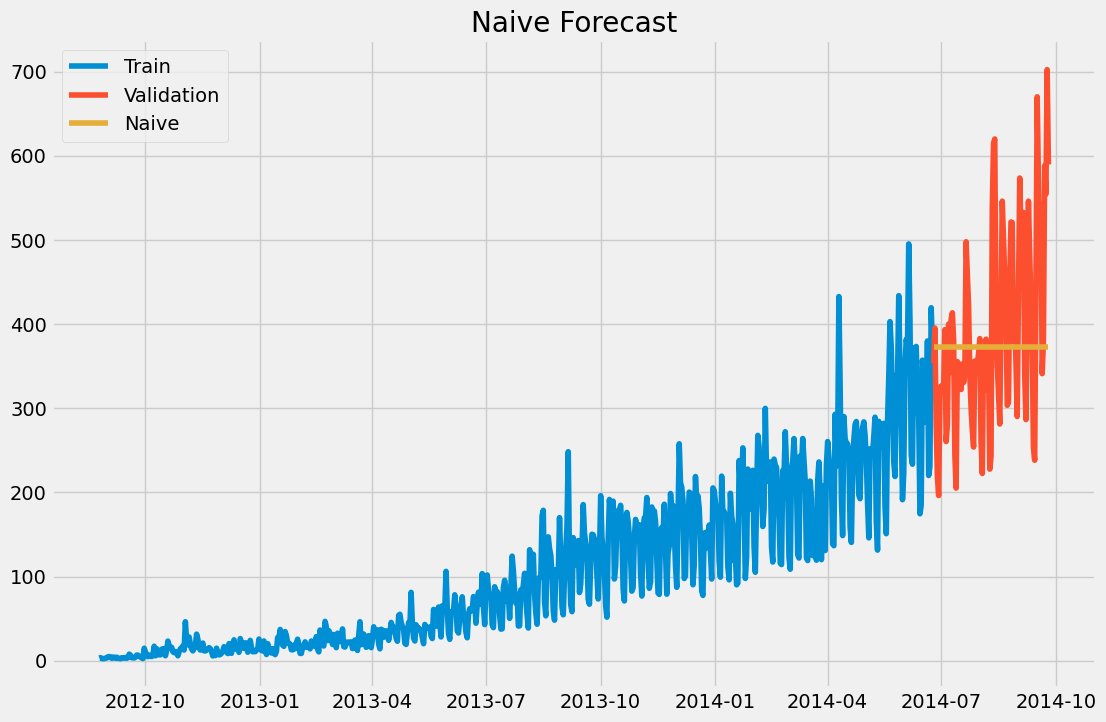

In [13]:
# Simple Naive Forecast Plot
dd = np.asarray(Train.Count)
y_hat =valid.copy()
y_hat['naive']= dd[len(dd)- 1]
plt.figure(figsize = (12,8))
plt.plot(Train.index, Train['Count'],label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'Validation')
plt.plot(y_hat.index, y_hat['naive'],  label = 'Naive')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

In [ ]:
# Choose windows to test
windows = [10, 20, 50]

results = []
preds_const = {}
preds_roll = {}

# Precompute a joined series for rolling-origin (so we can compute means up to t-1 cleanly)
y_all = pd.concat([y_train, y_valid])

for k in windows:
    # 1) Constant MA forecast: repeat the last rolling-mean from training across validation
    const_val = y_train.rolling(window=k, min_periods=1).mean().iloc[-1]
    y_pred_const = pd.Series(const_val, index=y_valid.index, name=f"MA{k}-const")
    preds_const[f"MA{k}-const"] = y_pred_const

    # 2) Rolling-origin MA forecast: at each t, average last k observed values up to t-1
    ma_series = y_all.rolling(window=k, min_periods=1).mean().shift(1)   # shift to avoid peeking
    y_pred_roll = ma_series.loc[y_valid.index].rename(f"MA{k}-roll")
    preds_roll[f"MA{k}-roll"] = y_pred_roll

def mae(y_true, y_pred):  return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return 100.0 * np.mean(np.abs((y_true - y_pred) / denom))

# Collect metrics
for name, series in {**preds_const, **preds_roll}.items():
    results.append({
        "Model": name,
        "MAE":  mae(y_valid, series),
        "RMSE": rmse(y_valid, series),
        "MAPE (%)": mape(y_valid, series)
    })

metrics_ma = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
print(metrics_ma.round(3))



                MAE     RMSE  MAPE (%)
Model                                 
MA7-roll     76.805   97.813    20.902
MA10-roll    77.994  101.419    20.856
MA20-roll    78.736  101.798    20.809
MA50-roll    80.903  104.330    20.239
MA7-const    96.414  129.528    22.612
MA20-const   97.298  130.450    22.764
MA10-const  100.908  134.237    23.403
MA50-const  110.333  144.192    25.191


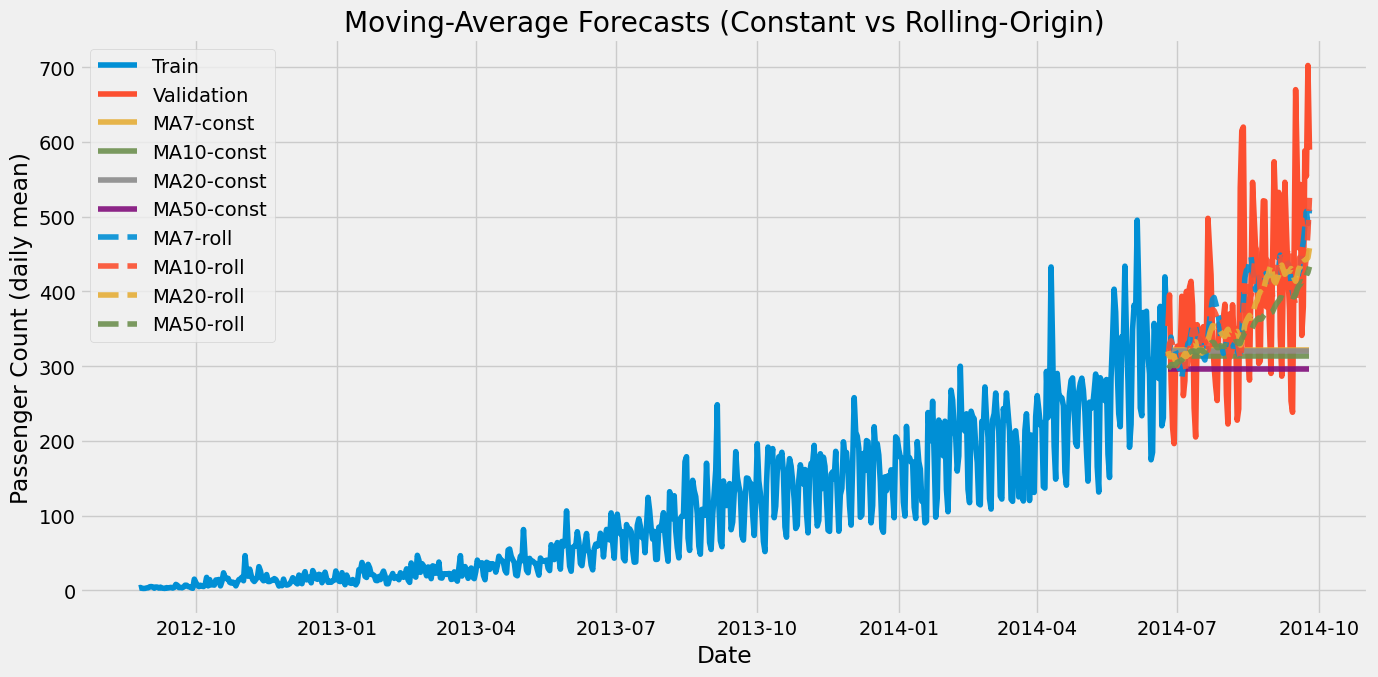

In [19]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_valid.index, y_valid, label="Validation")

# Plot constant and rolling-origin forecasts (keep it readable)
for name, series in preds_const.items():
    plt.plot(series.index, series.values, label=name, alpha=0.9)
for name, series in preds_roll.items():
    plt.plot(series.index, series.values, label=name, linestyle="--", alpha=0.9)

plt.title("Moving-Average Forecasts (Constant vs Rolling-Origin)")
plt.xlabel("Date")
plt.ylabel("Passenger Count (daily mean)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicting Time Series: ARIMA Model

Experiment with this ARIMA model by adjusting the rolling average and standard deviation windows.


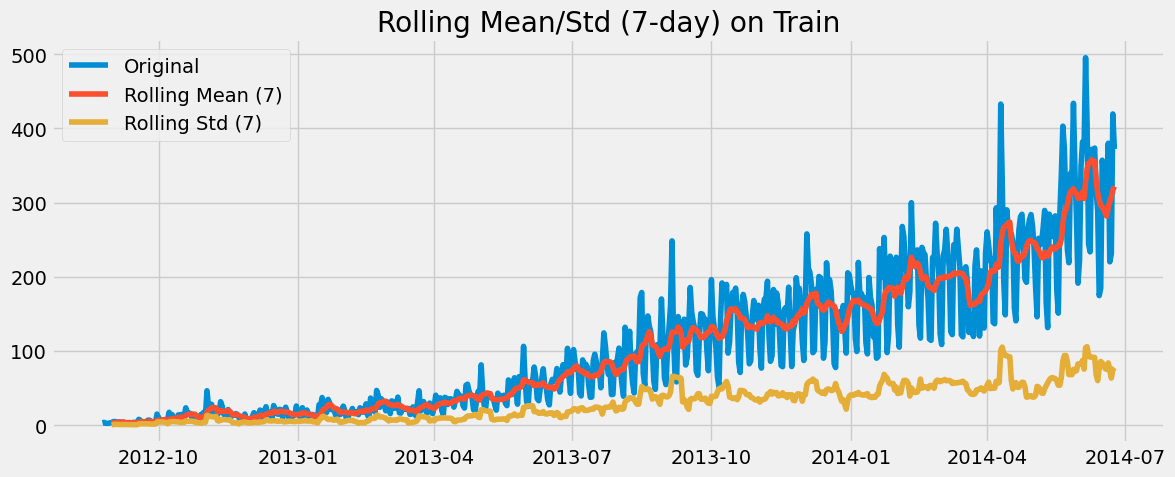

Results of Dickey–Fuller test:
Test Statistic            1.387308
p-value                   0.997056
# Lags Used              20.000000
# Observations          648.000000
Critical Value (1%)      -3.440482
Critical Value (5%)      -2.866011
Critical Value (10%)     -2.569151
dtype: float64
Suggested non-seasonal differencing d = 1


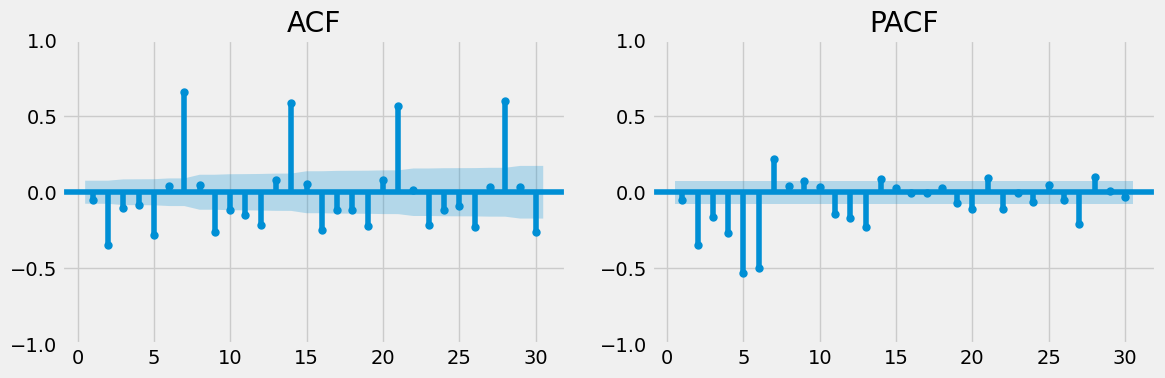

In [20]:
# ARIMA / SARIMA workflow (daily data, weekly seasonality) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Use your earlier split
y_train = Train['Count'].astype(float).copy()
y_valid = valid['Count'].astype(float).copy()

# 1) Stationarity diagnostics (ADF + rolling stats) 
def test_stationary(timeseries, window=7, title="Rolling Mean and Std"):
    rolmean = timeseries.rolling(window).mean()
    rolstd  = timeseries.rolling(window).std()

    plt.figure(figsize=(12, 5))
    plt.plot(timeseries, label="Original")
    plt.plot(rolmean, label=f"Rolling Mean ({window})")
    plt.plot(rolstd,  label=f"Rolling Std ({window})")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Results of Dickey–Fuller test:")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '# Lags Used', '# Observations'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Inspect stationarity on training data
test_stationary(y_train, window=7, title="Rolling Mean/Std (7-day) on Train")

# Decide differencing order d from ADF (very simple rule of thumb)
def suggest_d(series, max_d=2):
    d = 0
    s = series.copy()
    while d < max_d:
        pval = adfuller(s.dropna(), autolag='AIC')[1]
        if pval < 0.05:
            return d
        d += 1
        s = s.diff().dropna()
    return min(d, max_d)

d = suggest_d(y_train)
print(f"Suggested non-seasonal differencing d = {d}")

# --- 2) ACF/PACF (on differenced data if d>0) ---
series_for_corr = y_train.diff(d).dropna() if d > 0 else y_train
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_for_corr, ax=axes[0], lags=30, zero=False)
plot_pacf(series_for_corr, ax=axes[1], lags=30, zero=False, method='ywm')
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.tight_layout()
plt.show()



In [21]:

# --- 3) Fit ARIMA (non-seasonal) ---
# Small grid for (p,q); keep it quick and robust
pq_grid = [(p, q) for p in range(0, 4) for q in range(0, 4)]
best_aic = np.inf
best_order = None
best_model = None

for (p, q) in pq_grid:
    try:
        model = SARIMAX(y_train, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        if res.aic < best_aic:
            best_aic, best_order, best_model = res.aic, (p, d, q), res
    except Exception:
        continue

print(f"Best ARIMA order by AIC: {best_order}  (AIC={best_aic:.1f})")

# Forecast over validation horizon
fc_arima = best_model.get_forecast(steps=len(y_valid))
y_pred_arima = pd.Series(fc_arima.predicted_mean.values, index=y_valid.index, name=f"ARIMA{best_order}")

# --- 4) Fit SARIMA (weekly seasonality m=7) ---
m = 7
# Simple small seasonal grid (P,Q in {0,1}, D in {0,1})
seasonal_candidates = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)]
best_aic_s = np.inf
best_orders = None
best_model_s = None

for (p, q) in pq_grid:
    for (P, D, Q) in seasonal_candidates:
        try:
            model_s = SARIMAX(y_train,
                              order=(p, d, q),
                              seasonal_order=(P, D, Q, m),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
            res_s = model_s.fit(disp=False)
            if res_s.aic < best_aic_s:
                best_aic_s = res_s.aic
                best_orders = ((p, d, q), (P, D, Q, m))
                best_model_s = res_s
        except Exception:
            continue

print(f"Best SARIMA orders by AIC: {best_orders}  (AIC={best_aic_s:.1f})")

fc_sarima = best_model_s.get_forecast(steps=len(y_valid))
y_pred_sarima = pd.Series(fc_sarima.predicted_mean.values, index=y_valid.index,
                          name=f"SARIMA{best_orders}")


Best ARIMA order by AIC: (2, 1, 3)  (AIC=6374.5)
Best SARIMA orders by AIC: ((3, 1, 3), (1, 1, 1, 7))  (AIC=5929.8)


In [23]:

# --- 5) Metrics ---
def mae(y_true, y_pred):  return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return 100.0 * np.mean(np.abs((y_true - y_pred) / denom))

metrics = []
for name, pred in [("ARIMA", y_pred_arima), ("SARIMA", y_pred_sarima)]:
    metrics.append({
        "Model": name,
        "MAE":  mae(y_valid, pred),
        "RMSE": rmse(y_valid, pred),
        "MAPE (%)": mape(y_valid, pred)
    })
metrics_df = pd.DataFrame(metrics).set_index("Model").sort_values("RMSE")
print(metrics_df.round(3))


           MAE     RMSE  MAPE (%)
Model                            
SARIMA  53.764   68.668    13.698
ARIMA   83.219  105.883    19.735


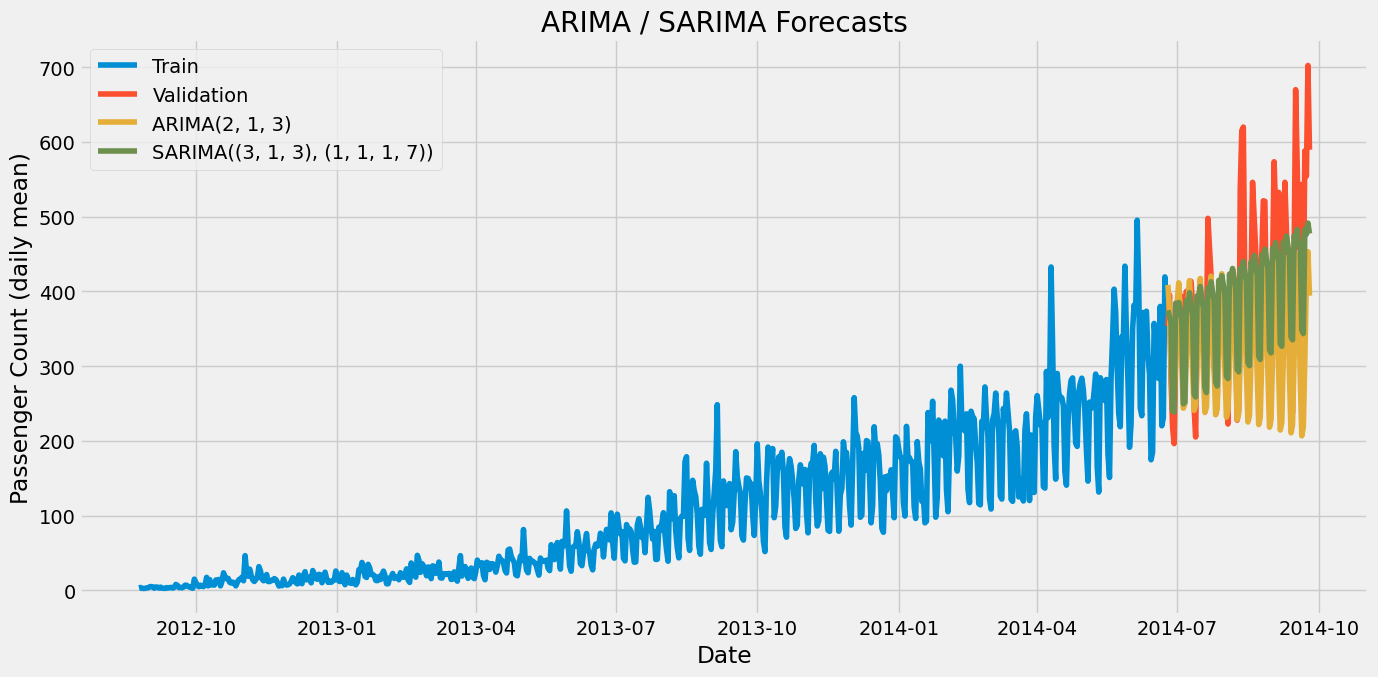

In [24]:
# --- 6) Plot forecasts vs actuals ---
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_valid.index, y_valid, label="Validation")
plt.plot(y_pred_arima.index, y_pred_arima, label=y_pred_arima.name)
plt.plot(y_pred_sarima.index, y_pred_sarima, label=y_pred_sarima.name)
plt.title("ARIMA / SARIMA Forecasts")
plt.xlabel("Date")
plt.ylabel("Passenger Count (daily mean)")
plt.legend()
plt.tight_layout()
plt.show()

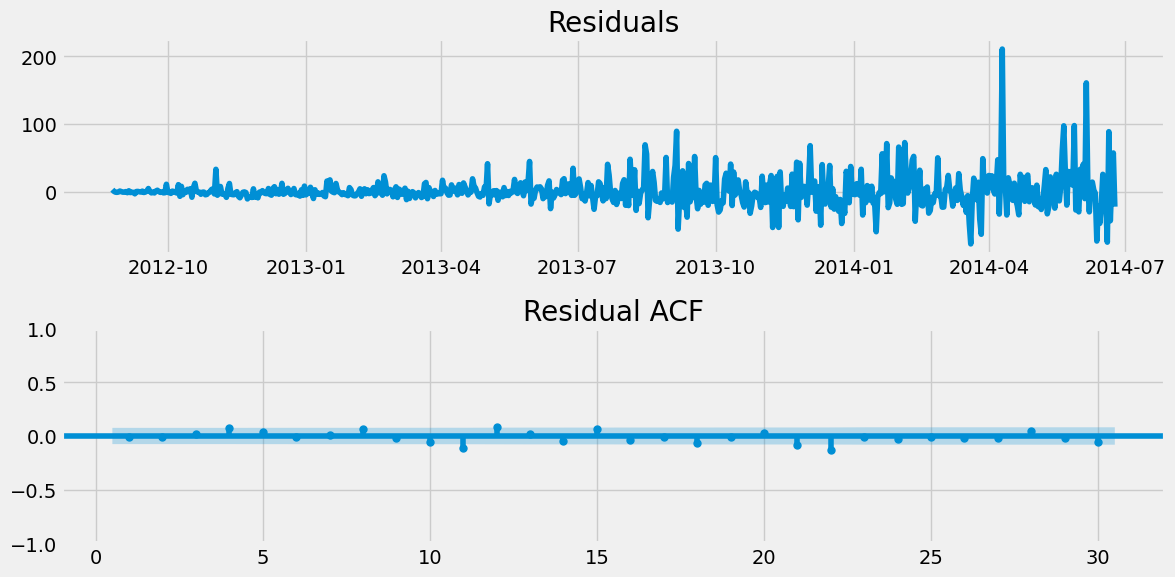

In [25]:
# Optional: residual diagnostics for the chosen SARIMA
resid = best_model_s.resid
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(resid)
ax[0].set_title("Residuals")
plot_acf(resid.dropna(), lags=30, zero=False, ax=ax[1])
ax[1].set_title("Residual ACF")
plt.tight_layout()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

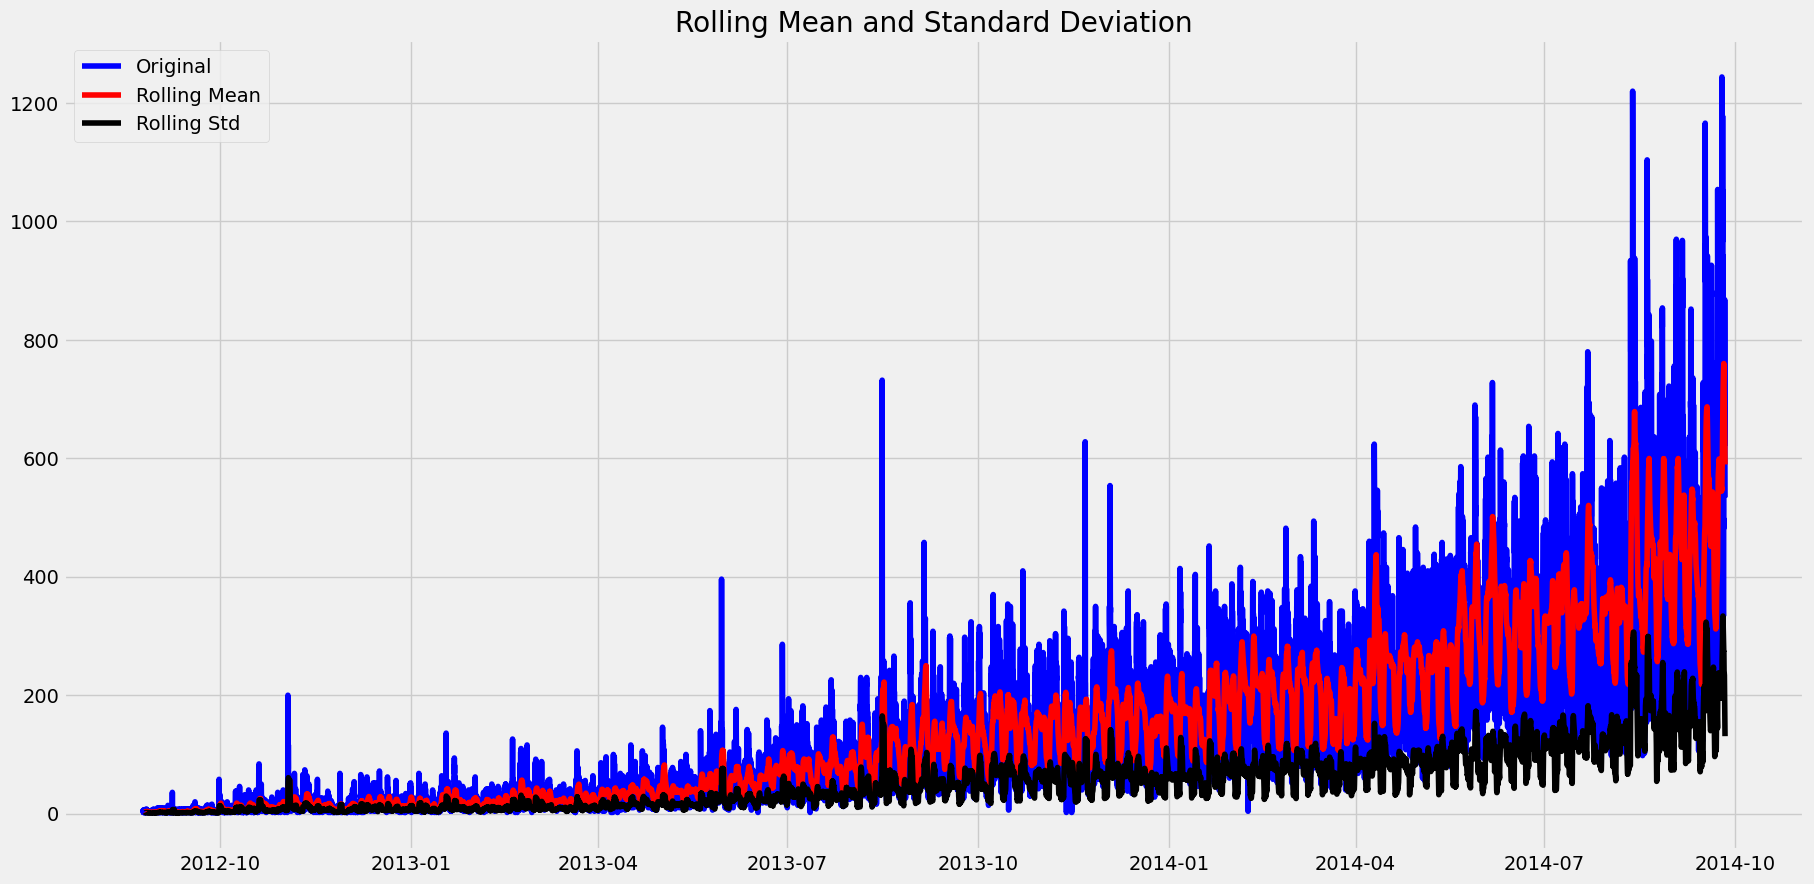

Results of Dickey Fuller test: 
Test Statistics                   -4.456561
p-value                            0.000235
# Lag Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(20,10)
test_stationary(train_original['Count'])

### Remove trends

In [28]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

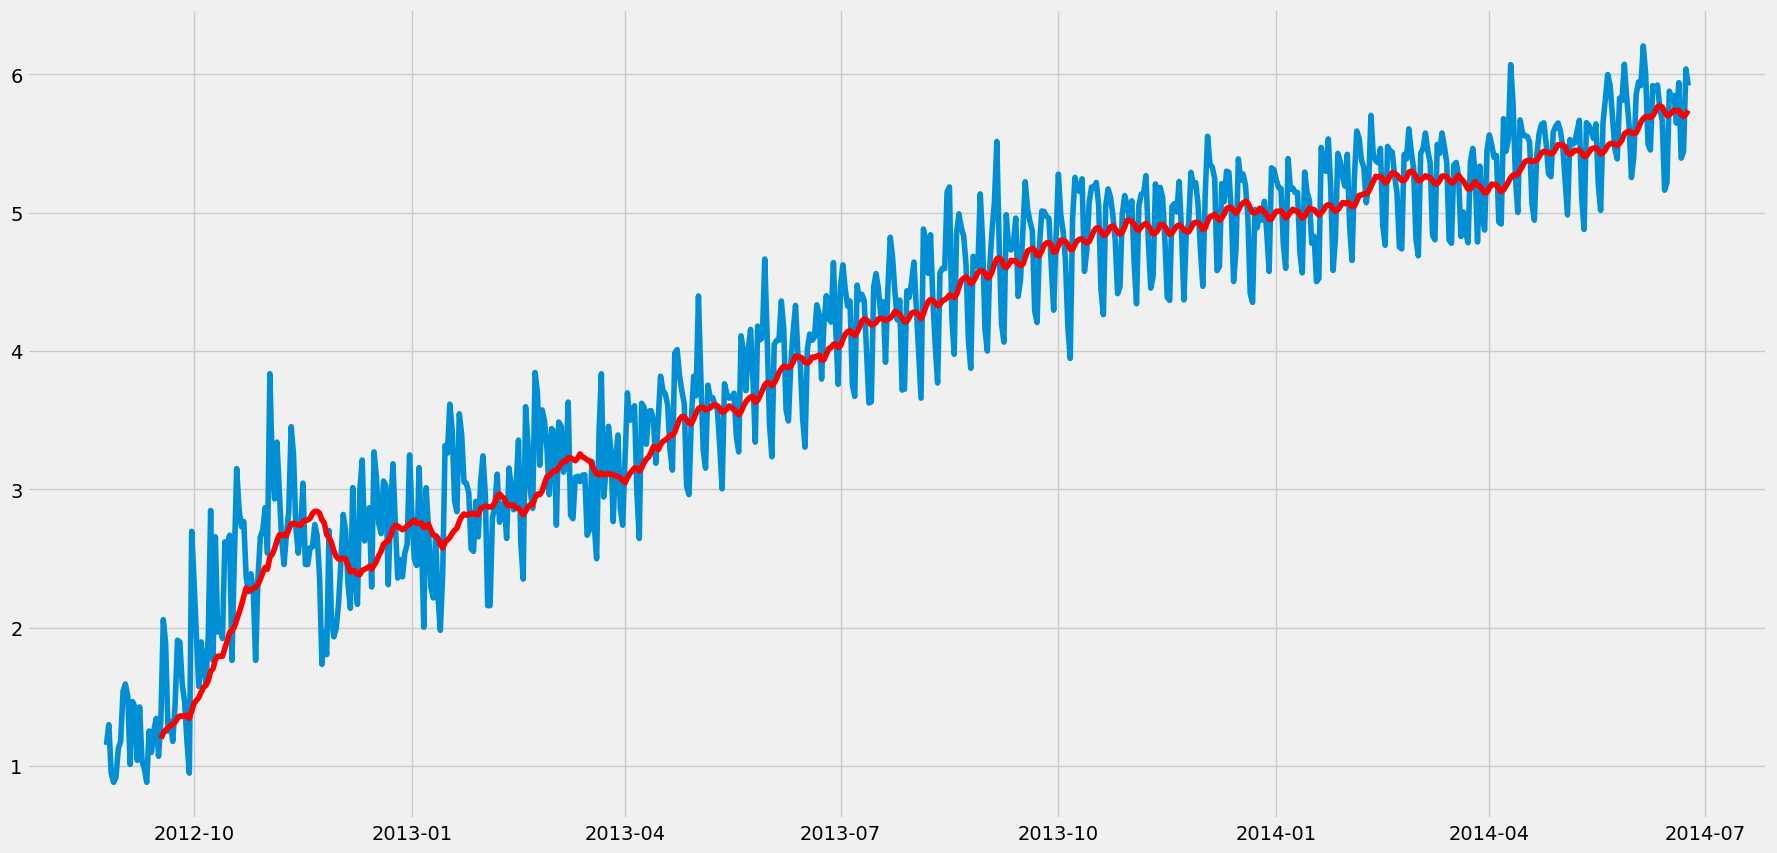

In [29]:
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')


In [ ]:
train_log_moving_diff = Train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)
test_stationary(train_log_moving_diff)

### Differencing can help to make the series stable and eliminate trends

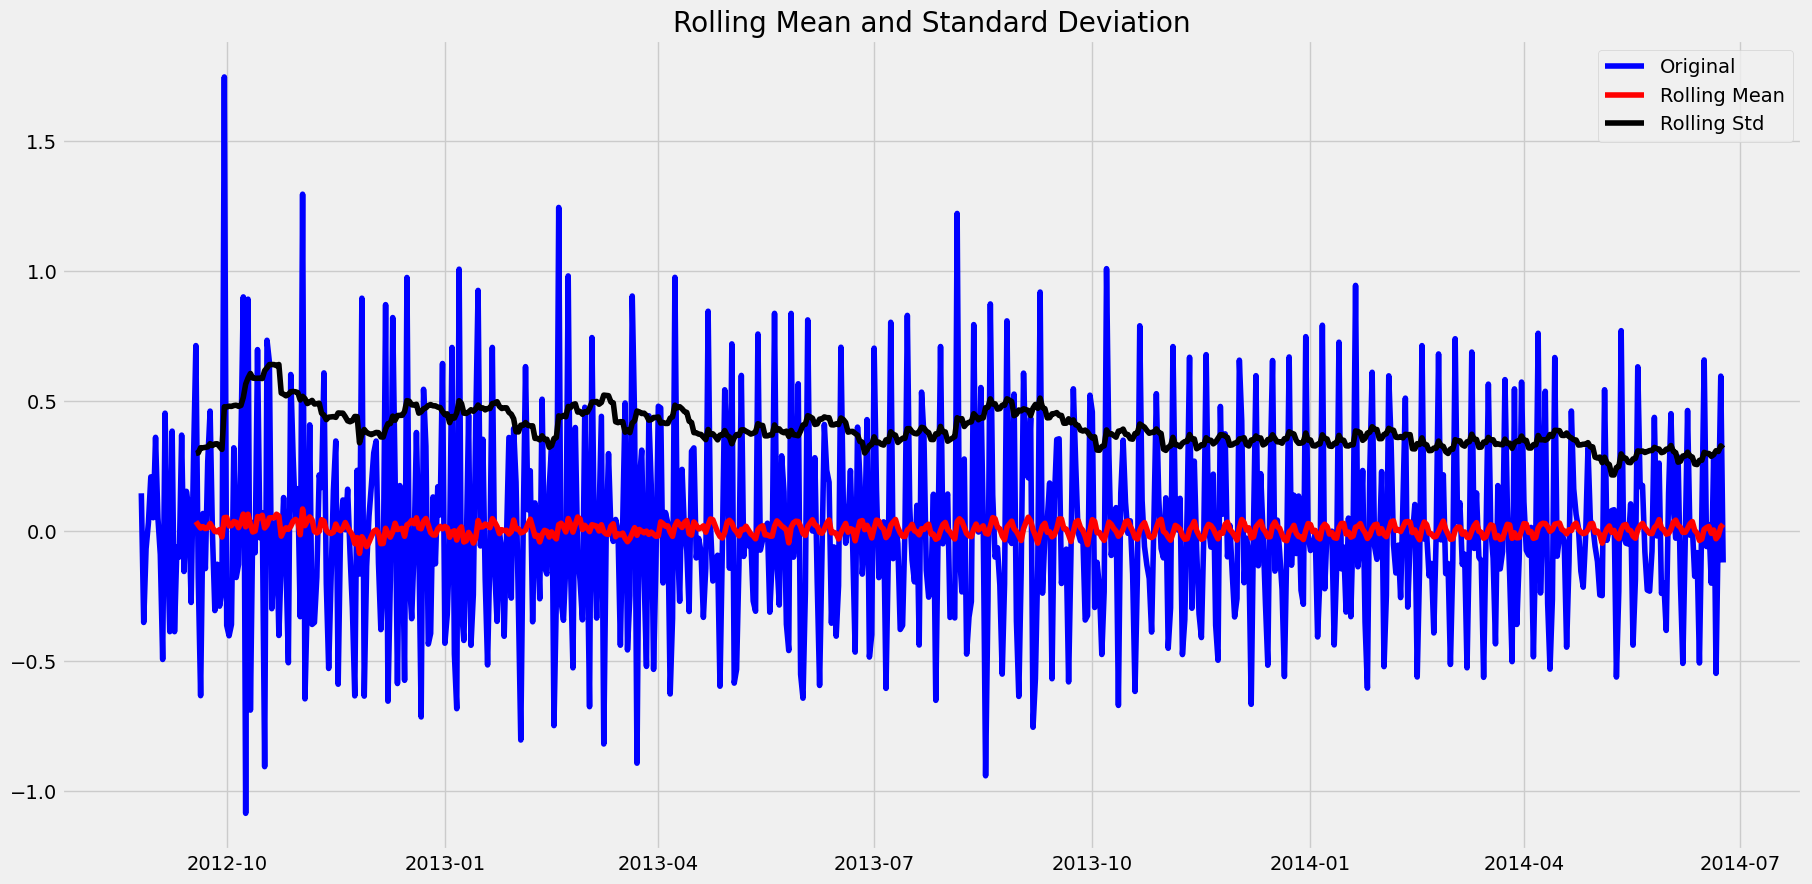

Results of Dickey Fuller test: 
Test Statistics               -8.237568e+00
p-value                        5.834049e-13
# Lag Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [30]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

### Removing Seasonailty and residuals

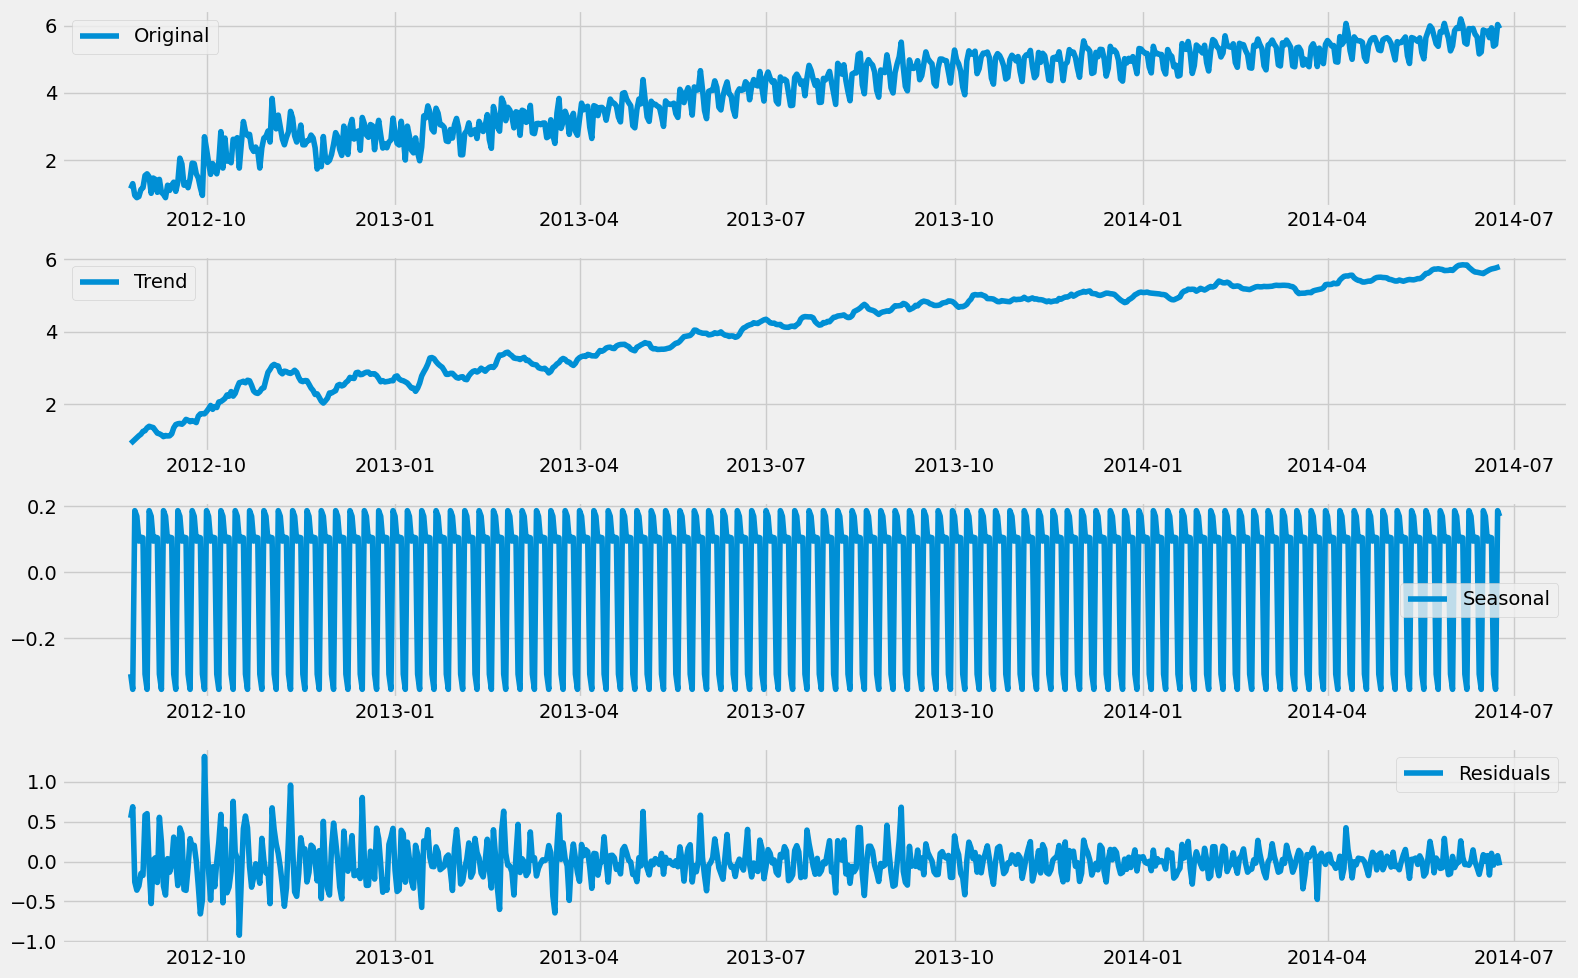

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Make sure the index has a fixed daily frequency
Train_log = Train_log.asfreq('D')

# Decompose: daily data → weekly seasonality
result = seasonal_decompose(Train_log, model='additive', period=7, extrapolate_trend='freq')

trend = result.trend
seasonal = result.seasonal
resid = result.resid

plt.figure(figsize=(16, 10))

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
